In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.paths import LOCAL_PROCESSED_DATA_PATH
from src.processing.dialogre_processing import DialogREDatasetTransformer
from src.processing.ner_evaluator import EntityMetricsEvaluator
from src.processing.dataframe_utils import get_counts_and_percentages
from src.utils import handle_exceptions
from tqdm import tqdm
tqdm.pandas()




dt = DialogREDatasetTransformer(LOCAL_PROCESSED_DATA_PATH / 'dialog-re-with-no-relation')
df1 = dt.load_data_to_dataframe()


In [4]:
import json
from src.processing.text_preprocessing import CoreferenceResolver, FeatureExtractor

coref_resolver = CoreferenceResolver()
extractor = FeatureExtractor()

# output_dicts = extractor.process_dialogue(resolved_dialogue, entities)

07/09/2023 15:12:21 - INFO - 	 missing_keys: []
07/09/2023 15:12:21 - INFO - 	 unexpected_keys: []
07/09/2023 15:12:21 - INFO - 	 mismatched_keys: []
07/09/2023 15:12:21 - INFO - 	 error_msgs: []
07/09/2023 15:12:21 - INFO - 	 Model Parameters: 90.5M, Transformer: 82.1M, Coref head: 8.4M


In [25]:
df1.Dialogue.apply(len).head(20)

0     24
1      7
2     10
3      9
4      1
5      7
6      6
7     11
8      9
9     19
10    15
11     7
12    10
13    15
14     4
15     9
16    14
17     9
18    26
19     6
Name: Dialogue, dtype: int64

In [127]:
idx = 2
dialogue = df1.iloc[idx].Dialogue
entity_pairs = df1.Relations.apply(lambda relations: [(r['x'], r['y']) for r in relations]).iloc[idx]

resolved_dialogue = coref_resolver.process_dialogue(dialogue)
dialogue, resolved_dialogue


07/09/2023 16:08:29 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

07/09/2023 16:08:30 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

(['Speaker 1, Speaker 2: Hi!',
  'Speaker 3: Hey!',
  'Speaker 4: So glad you came!',
  "Speaker 1: I can't believe Emma is already one!",
  'Speaker 2: I remember your first birthday! Ross was jealous of all the attention we were giving you. He pulled on his testicles so hard! We had to take him to the emergency room!',
  "Speaker 3: There's something you didn't know about your dad!",
  'Speaker 5: Hey Mr. and Mrs. Geller! Let me help you with that.',
  'Speaker 1: Thank you!',
  'Speaker 5: Oh man, this is great, uh? The three of us together again! You know what would be fun? If we gave this present to Emma from all of us!',
  'Speaker 1: Which one are you?'],
 ['Speaker 1, Speaker 2: Hi!',
  'Speaker 3: Hey!',
  'Speaker 4: So glad you came!',
  "Speaker 1: Speaker 1 can't believe Emma is already one!",
  "Speaker 2: I remember Emma's first birthday! Ross was jealous of all the attention we were giving Emma. Ross pulled on Ross's testicles so hard! We had to take Ross to the emergen

In [142]:
class DialogueReducer:
    def __init__(self, split_by='turn'):
        self.nlp = spacy.load("en_core_web_sm")
        self.split_by = split_by

    def _split_dialogue(self, dialogue):
        if self.split_by == 'turn':
            return dialogue.split('\n')
        elif self.split_by == 'sentence':
            doc = self.nlp(dialogue)
            return [str(sent) for sent in doc.sents]
        else:
            raise ValueError("Invalid value for split_by. Expected 'turn' or 'sentence'.")

    def _update_indices(self, i, sent, entity1, entity2, start_index, end_index, split_on_colon=False):
        if split_on_colon:
            content = sent.split(":", 1)[-1]  # This will get the content after the first ":"
        else:
            content = sent
        if entity1 in content or entity2 in content:
            if start_index is None:
                start_index = i
            end_index = i
        return start_index, end_index

    def _extract_sub_dialogue(self, dialogue_list, start_index, end_index):
        if start_index is not None and end_index is not None:
            return dialogue_list[start_index:end_index+1]
    
    def get_sub_dialogues(self, dialogue, entity_pairs):
        dialogue_list = self._split_dialogue(dialogue)
        all_sub_dialogues = {}
        for pair in entity_pairs:
            all_sub_dialogues[pair] = []
            start_index = None
            end_index = None
            for i, sent in enumerate(dialogue_list):
                start_index, end_index = self._update_indices(i, sent, *pair, start_index, end_index)
            if start_index is not None and end_index is not None:
                sub_dialogue = self._extract_sub_dialogue(dialogue_list, start_index, end_index)
                all_sub_dialogues[pair].append(sub_dialogue)
        
        shortest_sub_dialogues = {pair: max(dialogues, key=len) for pair, dialogues in all_sub_dialogues.items() if dialogues}
        return shortest_sub_dialogues



reducer = DialogueReducer(split_by='turn')
# sub_dialogues = reducer.get_sub_dialogues('\n'.join(resolved_dialogue), entity_pairs)

# sub_dialogues

In [143]:
@handle_exceptions
def resolve_dialogue(dialogue):
    return coref_resolver.process_dialogue(dialogue)

df1['ResolvedDialogue'] = df1.Dialogue.progress_apply(resolve_dialogue)

In [138]:
df1[df1.ResolvedDialogue.isna()]

,Dialogue,Relations,Origin,ResolvedDialogue
1120,"[Speaker 1: Here you are., Speaker 2: Thank yo...","[{'y': 'Speaker 2', 'x': 'Dr. Wiener', 'rid': ...",train,None
1236,"[Speaker 1: Hey! Hey alright! Hey, glad you co...","[{'y': 'Speaker 3', 'x': 'Speaker 2', 'rid': [...",train,None
1511,"[Speaker 1: Good evening, sir. My name is Ross...","[{'y': 'Speaker 1', 'x': 'Speaker 3', 'rid': [...",train,None


In [141]:
tmp = df1.explode('Relations')

@handle_exceptions
def extract_sub_dialogues(row, resolve_coref=True):
    relations = (row['Relations']['x'], row['Relations']['y'])
    if resolve_coref:
        dialogue = '\n'.join(row['ResolvedDialogue'])
    else:
        dialogue = '\n'.join(row['Dialogue'])
    sub_dialogues = reducer.get_sub_dialogues(dialogue, [relations])
    return list(sub_dialogues.values())[0] if sub_dialogues else None

tmp['SubDialogue'] = tmp.progress_apply(extract_sub_dialogues, axis=1)


100%|██████████| 26238/26238 [00:01<00:00, 17669.51it/s]


In [166]:
tmp['SubDialogue'] = tmp['SubDialogue'].fillna(tmp['Dialogue'])

In [167]:

# Assuming your dataset is stored in a DataFrame called 'df'
tmp['SubDialogue'] = tmp['SubDialogue'].astype(str)  # Convert SubDialogue column to string

tmp = tmp.reset_index()

grouped_df = tmp.groupby('SubDialogue').agg({
    'index': lambda x: max(x),
    'Dialogue': lambda x: max(x),
    'Relations': lambda x: list(x),
    'Origin': lambda x: max(x)
}).reset_index()

grouped_df['SubDialogue'] = grouped_df['SubDialogue'].apply(eval)  # Convert SubDialogue column back to list


<Axes: ylabel='Frequency'>

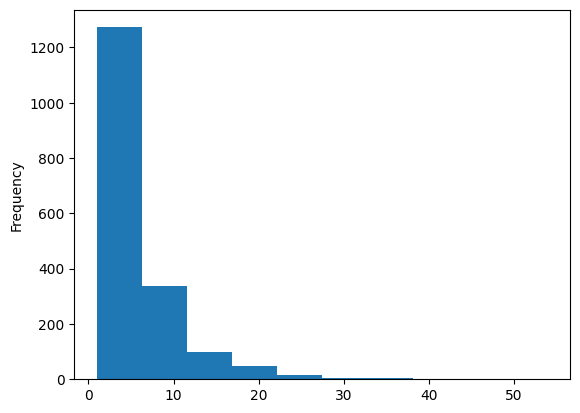

In [180]:
grouped_df['index'].value_counts().plot(kind='hist')

In [183]:
print(grouped_df)

                                             SubDialogue  index  \
0                                                   None   1769   
1      [Speaker 1:  'Hi, I have Phoebe Buffay returni...   1174   
2      [Speaker 1:  'Hi, I have Phoebe Buffay returni...   1174   
3      [Speaker 1:  Hey, my little boy's not crying.,...    810   
4      [Speaker 1:  Hey, my little boy's not crying.,...    810   
...                                                  ...    ...   
10176  [Speaker 8: Rach?, Speaker 2: Oh yeah, sorry. ...    585   
10177  [Speaker 8: Rach?, Speaker 2: Oh yeah, sorry. ...    585   
10178  [Speaker 8: Thank Phoebe!, Speaker 3: No! Than...    519   
10179  [Speaker 8: Well, this is ironic. Of your last...    501   
10180      [Speaker 9: Not for me. Chip and I broke up!]    380   

                                                Dialogue  \
0      [Speaker 1:: Tribbiani! Hold on, I’ll get the ...   
1      [Speaker 1: Oh, it's your audition from this m...   
2      [Speaker

In [207]:
# Assuming your dataset is stored in a DataFrame called 'grouped_df'
import os
import json


# Get the unique values in the 'Origin' column
origins = grouped_df['Origin'].unique()

# Dump the dataset as JSON files for each group in the 'Origin' column
for origin in origins:
    filtered_df = grouped_df[grouped_df['Origin'] == origin]
    data = filtered_df.to_dict(orient='records')

    # Assuming your dataset is stored in a variable called 'data'

    formatted_data = []

    for row in data:
        subdialogue = row['SubDialogue']
        dialogue = row['Dialogue']
        relations = row['Relations']
        
        formatted_subdialogue = []
        formatted_subdialogue.append(dialogue)
        formatted_subdialogue.append(relations)
        
        formatted_data.append(formatted_subdialogue)

    directory = LOCAL_PROCESSED_DATA_PATH / f'dialog-re-subdialogues'
    if not os.path.exists(directory):
        os.makedirs(directory)


    with open(directory / f'{origin}.json', 'w') as f:
        json.dump(formatted_data, f)
